In [1]:
import pandas as pd
import numpy as np
import h3
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
trips_data = pd.read_csv('data/Taxi_Trips__2024-__20250711.csv') 
trips_data['Trip Start Timestamp'] = pd.to_datetime(trips_data['Trip Start Timestamp'])
trips_data[trips_data['Trip Start Timestamp'] > '2025-06-30']


In [3]:
trips_data.loc[trips_data['Pickup Census Tract'].isna(), 'Pickup Centroid Latitude'] = np.nan
trips_data.loc[trips_data['Pickup Census Tract'].isna(), 'Pickup Centroid Longitude'] = np.nan

trips_data.loc[trips_data['Dropoff Census Tract'].isna(), 'Dropfoff Centroid Latitude'] = np.nan
trips_data.loc[trips_data['Dropoff Census Tract'].isna(), 'Dropoff Centroid Longitude'] = np.nan

# Locational EDA

In [4]:
h3_resolution = 9

def latlon_to_h3(lat, lon, res=h3_resolution):
    if pd.isnull(lat) or pd.isnull(lon):
        return None
    return h3.latlng_to_cell(lat, lon, res)


trips_data['Pickup H3'] = trips_data.apply(
    lambda row: latlon_to_h3(row['Pickup Centroid Latitude'], row['Pickup Centroid Longitude']), axis=1
)
trips_data['Dropoff H3'] = trips_data.apply(
    lambda row: latlon_to_h3(row['Dropoff Centroid Latitude'], row['Dropoff Centroid Longitude']), axis=1
)

In [5]:

for bin_hours in [1, 4, 8, 24]:
    col = f'time_bin_{bin_hours}hr'
    trips_data[col] = trips_data['Trip Start Timestamp'].dt.floor(f'{bin_hours}H')


C:\Users\LIWFG\AppData\Local\Temp\ipykernel_6000\1011730991.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trips_data['Trip Start Timestamp'] = pd.to_datetime(trips_data['Trip Start Timestamp'])
C:\Users\LIWFG\AppData\Local\Temp\ipykernel_6000\1011730991.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips_data[col] = trips_data['Trip Start Timestamp'].dt.floor(f'{bin_hours}H')
C:\Users\LIWFG\AppData\Local\Temp\ipykernel_6000\1011730991.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips_data[col] = trips_data['Trip Start Timestamp'].dt.floor(f'{bin_hours}H')
C:\Users\LIWFG\AppData\Local\Temp\ipykernel_6000\1011730991.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trip

In [7]:
results = {}

pickup = trips_data['Pickup Census Tract'].dropna().value_counts().head(1)
dropoff = trips_data['Dropoff Census Tract'].dropna().value_counts().head(1)

tract_route_valid = trips_data.dropna(subset=['Pickup Census Tract', 'Dropoff Census Tract']).copy()
tract_route_valid['tract_route'] = (
    tract_route_valid['Pickup Census Tract'].astype(str) + '→' + tract_route_valid['Dropoff Census Tract'].astype(str)
)
route = tract_route_valid['tract_route'].value_counts().head(1)

pickup_h3 = trips_data['Pickup H3'].dropna().value_counts().head(1)
dropoff_h3 = trips_data['Dropoff H3'].dropna().value_counts().head(1)

h3_route_valid = trips_data.dropna(subset=['Pickup H3', 'Dropoff H3']).copy()
h3_route_valid['h3_route'] = (
    h3_route_valid['Pickup H3'].astype(str) + '→' + h3_route_valid['Dropoff H3'].astype(str)
)
route_h3 = h3_route_valid['h3_route'].value_counts().head(1)

results['all'] = {
    'pickup': pickup,
    'dropoff': dropoff,
    'route': route,
    'pickup_h3': pickup_h3,
    'dropoff_h3': dropoff_h3,
    'route_h3': route_h3
}

In [8]:
summary = results['all']
print("Most common Pickup Census Tract:\n", summary['pickup'])
print("Most common Dropoff Census Tract:\n", summary['dropoff'])
print("Most common Route (Tracts):\n", summary['route'])
print("Most common Pickup H3:\n", summary['pickup_h3'])
print("Most common Dropoff H3:\n", summary['dropoff_h3'])
print("Most common Route (H3):\n", summary['route_h3'])

Most common Pickup Census Tract:
 Pickup Census Tract
1.703198e+10    1024028
Name: count, dtype: int64
Most common Dropoff Census Tract:
 Dropoff Census Tract
1.703184e+10    574837
Name: count, dtype: int64
Most common Route (Tracts):
 tract_route
17031980000.0→17031980000.0    119974
Name: count, dtype: int64
Most common Pickup H3:
 Pickup H3
89275934ed3ffff    1024028
Name: count, dtype: int64
Most common Dropoff H3:
 Dropoff H3
892664c1a8bffff    574837
Name: count, dtype: int64
Most common Route (H3):
 h3_route
89275934ed3ffff→89275934ed3ffff    119974
Name: count, dtype: int64


In [18]:
summary['route_h3']

h3_route
89275934ed3ffff→89275934ed3ffff    119974
Name: count, dtype: int64

In [19]:
route = route_h3.index[0]
route_pickup, route_dropoff = route.split('→')

center_lat = trips_data['Pickup Centroid Latitude'].mean()
center_lon = trips_data['Pickup Centroid Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

def add_h3_hex(m, h3_index, color):
    if pd.isnull(h3_index):
        return
    boundary = h3.cell_to_boundary(h3_index)
    folium.Polygon(locations=boundary, color=color, fill=True, fill_opacity=0.4).add_to(m)

add_h3_hex(m, route_pickup, 'blue')
add_h3_hex(m, route_dropoff, 'red')

#m.save("most_common_hexes_24hr.html")
m

In [13]:
import folium

pickup_h3_24 = results['all']['pickup_h3']
dropoff_h3_24 = results['all']['dropoff_h3']

center_lat = trips_data['Pickup Centroid Latitude'].mean()
center_lon = trips_data['Pickup Centroid Longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='CartoDB positron')

def add_h3_hex(m, h3_index, color):
    if pd.isnull(h3_index):
        return
    boundary = h3.cell_to_boundary(h3_index)
    folium.Polygon(locations=boundary, color=color, fill=True, fill_opacity=0.4).add_to(m)

for h3_index in pickup_h3_24.index:
    add_h3_hex(m, h3_index, 'blue')
for h3_index in dropoff_h3_24.index:
    add_h3_hex(m, h3_index, 'red')

#m.save("most_common_hexes_24hr.html")
m

# Financial EDA

In [ ]:
total_gross_revenue = trips_data['Trip Total'].sum()

In [ ]:
trips_data['Trip Start Timestamp'] = pd.to_datetime(trips_data['Trip Start Timestamp'])
trips_data['Month'] = trips_data['Trip Start Timestamp'].dt.to_period('M').astype(str)
trips_data['Hour'] = trips_data['Trip Start Timestamp'].dt.hour

In [ ]:
avg_rev_month = trips_data.groupby('Month')['Trip Total'].mean().sort_index()
print("Average Revenue per Trip by Month:")
print(avg_rev_month)

Average Revenue per Trip by Month:
Month
2024-01    27.446235
2024-02    26.971253
2024-03    27.560358
2024-04    28.161282
2024-05    29.536942
2024-06    29.217126
2024-07    28.775607
2024-08    28.975718
2024-09    29.993381
2024-10    29.347386
2024-11    28.570945
2024-12    26.464235
2025-01    26.345970
2025-02    26.257503
2025-03    27.345772
2025-04    27.384409
2025-05    28.019869
2025-06    28.081683
2025-07    38.017000
Name: Trip Total, dtype: float64


In [ ]:
avg_rev_hour = trips_data.groupby('Hour')['Trip Total'].mean().sort_index()
print("\nAverage Revenue per Trip by Hour of Day:")
print(avg_rev_hour)


Average Revenue per Trip by Hour of Day:
Hour
0     34.925874
1     33.328058
2     29.768317
3     30.255840
4     35.302411
5     36.101976
6     30.257929
7     24.869369
8     23.136544
9     24.751083
10    26.041349
11    26.079985
12    26.788597
13    27.989720
14    28.138894
15    28.277155
16    26.953251
17    27.470777
18    27.543420
19    30.213830
20    33.003510
21    32.390906
22    31.633152
23    32.879534
Name: Trip Total, dtype: float64


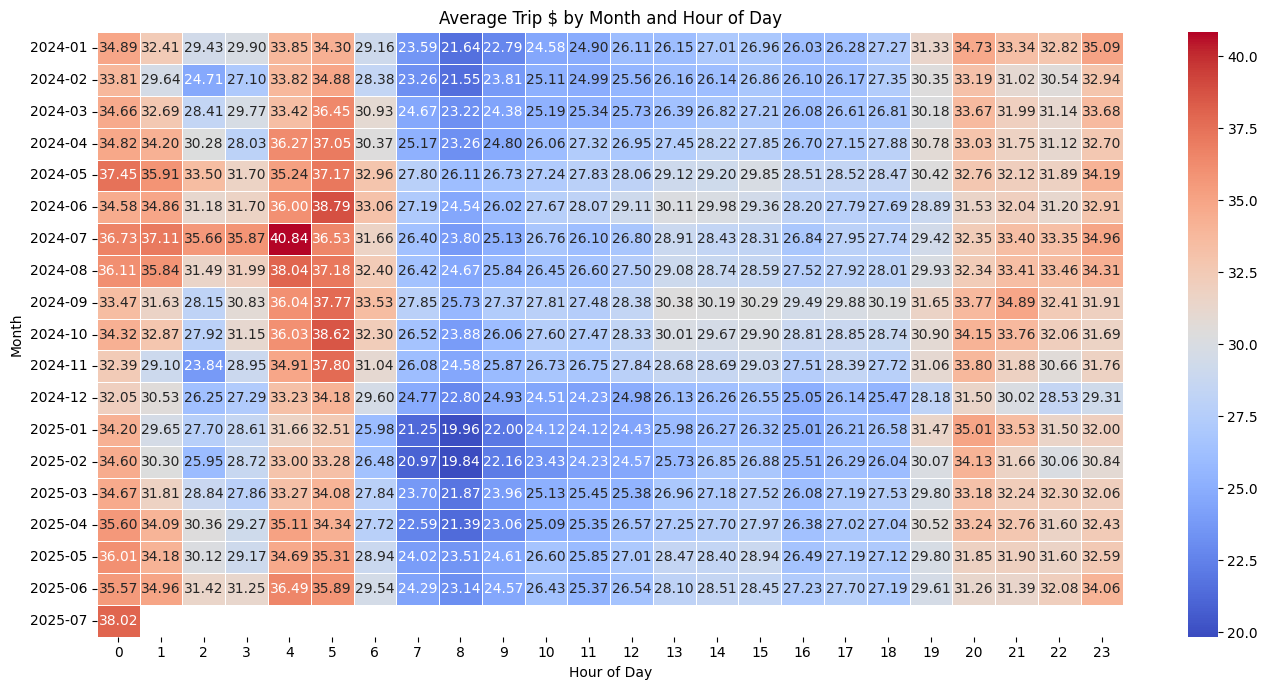

In [ ]:
pivot = trips_data.pivot_table(
    index='Month',
    columns='Hour',
    values='Trip Total',
    aggfunc='mean'
)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Average Trip $ by Month and Hour of Day')
plt.ylabel('Month')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.show()


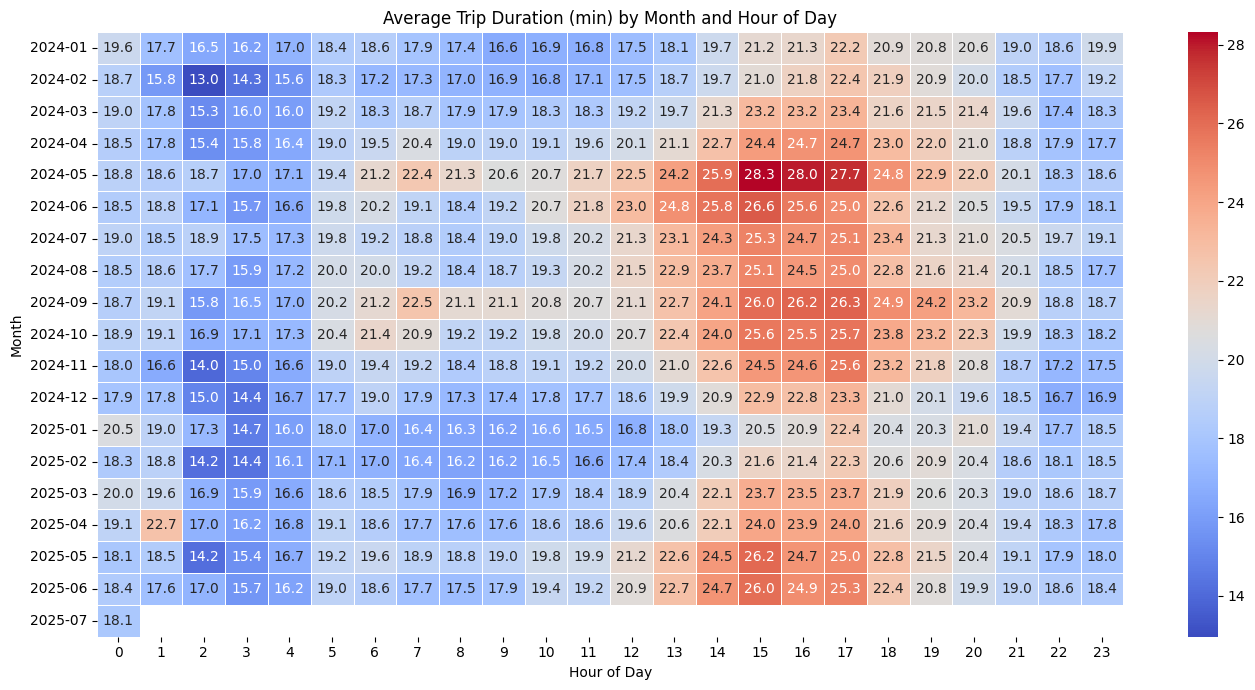

In [ ]:
trips_data['Trip Duration (min)'] = trips_data['Trip Seconds'] / 60

pivot_duration = trips_data.pivot_table(
    index='Month',
    columns='Hour',
    values='Trip Duration (min)',
    aggfunc='mean'
)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_duration, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5)
plt.title('Average Trip Duration (min) by Month and Hour of Day')
plt.ylabel('Month')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.show()

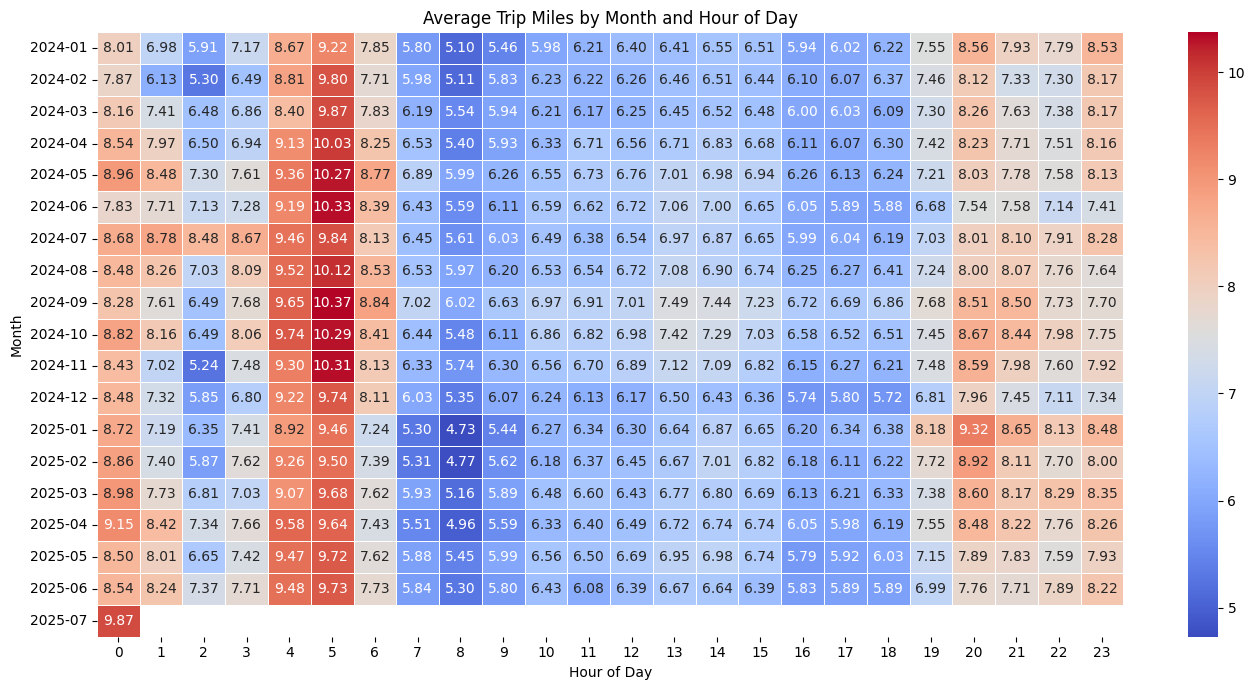

In [ ]:
pivot_miles = trips_data.pivot_table(
    index='Month',
    columns='Hour',
    values='Trip Miles',
    aggfunc='mean'
)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot_miles, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Average Trip Miles by Month and Hour of Day')
plt.ylabel('Month')
plt.xlabel('Hour of Day')
plt.tight_layout()
plt.show()

In [ ]:
max_trip = trips_data.loc[trips_data['Trip Total'].idxmax()]

top_taxi = trips_data.groupby('Taxi ID')['Trip Total'].sum().sort_values(ascending=False)
top_taxi_id = top_taxi.idxmax()

price_per_mile_data = trips_data[(trips_data['Trip Miles'] > 0) & (trips_data['Trip Total'] > 0)]
price_per_mile_data['Price per Mile'] = price_per_mile_data['Trip Total'] / price_per_mile_data['Trip Miles']
avg_per_trip = price_per_mile_data['Price per Mile'].mean()

C:\Users\LIWFG\AppData\Local\Temp\ipykernel_16168\3907608843.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_per_mile_data['Price per Mile'] = price_per_mile_data['Trip Total'] / price_per_mile_data['Trip Miles']


In [ ]:
print(f"\n==== Financial Summary ====")
print(f"Total Gross Revenue: ${total_gross_revenue:,.2f}")
print(f"Highest Grossing Trip: {max_trip['Trip ID']} (${max_trip['Trip Total']:.2f}) by Taxi ID {max_trip['Taxi ID']}")
print(f"Taxi with Highest Total Revenue: {top_taxi_id} (${top_taxi.loc[top_taxi_id]:,.2f})")
print(f"Average (Per-Trip) Price per Mile: ${avg_per_trip:.2f}")


==== Financial Summary ====
Total Gross Revenue: $274,704,462.68
Highest Grossing Trip: 097168baad7b870246a05e4811300d303b6e8e37 ($9999.75) by Taxi ID a9ee5e97ba7efef90f445edbd32726cbbc44fd4fd47bc5ef858403ed8dfd7a5b6193145ff5a4ee0d0142a6810518e0498d822062f3aa3052c20b09e0952e3d6d
Taxi with Highest Total Revenue: 00e34f77f4495a6128d5b3312099c8f2f4ea25c2650e83e22eb49bc21b5d75f4a4ef34b591c3277204065541df3d4575f0cf5b63d37e594e0021667768d1ba30 ($823,921.39)
Average (Per-Trip) Price per Mile: $17.54


# Single Taxi Evaluation

In [ ]:
taxi_ride_counts = trips_data['Taxi ID'].value_counts()
most_active_taxi = taxi_ride_counts.idxmax()
rides_by_most_active = taxi_ride_counts.max()

most_active_taxi_trips = trips_data[trips_data['Taxi ID'] == most_active_taxi]
highest_trip_total = most_active_taxi_trips['Trip Total'].max()
highest_trip_row = most_active_taxi_trips.loc[most_active_taxi_trips['Trip Total'].idxmax()]

most_active_taxi_trips['Date'] = most_active_taxi_trips['Trip Start Timestamp'].dt.date
daily_counts = most_active_taxi_trips.groupby('Date').size()
daily_gross = most_active_taxi_trips.groupby('Date')['Trip Total'].sum()
avg_rides_per_day = daily_counts.mean()

avg_trip_length = most_active_taxi_trips['Trip Miles'].mean()
avg_trip_duration = most_active_taxi_trips['Trip Seconds'].mean() / 60

most_active_taxi_trips['Date'] = most_active_taxi_trips['Trip Start Timestamp'].dt.date
daily_gross = most_active_taxi_trips.groupby('Date')['Trip Total'].sum()
highest_gross_day = daily_gross.idxmax()
highest_gross_amt = daily_gross.max()

avg_gross_per_day = daily_gross.mean()

C:\Users\LIWFG\AppData\Local\Temp\ipykernel_16168\3799170559.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_active_taxi_trips['Date'] = most_active_taxi_trips['Trip Start Timestamp'].dt.date
C:\Users\LIWFG\AppData\Local\Temp\ipykernel_16168\3799170559.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_active_taxi_trips['Date'] = most_active_taxi_trips['Trip Start Timestamp'].dt.date


In [ ]:
print("\n===== Most Active Taxi Financial Summary =====")
print(f"Taxi ID: {most_active_taxi}")
print(f"Total Rides: {rides_by_most_active}")
print(f"Highest Trip Total: ${highest_trip_total:.2f} (Trip ID: {highest_trip_row['Trip ID']})")
print(f"Highest Grossing Day: {highest_gross_day} (${highest_gross_amt:.2f})")
print(f"Average Rides per Day: {avg_rides_per_day:.2f}")
print(f"Average Gross per Day: ${avg_gross_per_day:.2f}")
print(f"Average Trip Length (miles): {avg_trip_length:.2f}")
print(f"Average Trip Duration (minutes): {avg_trip_duration:.2f}")


===== Most Active Taxi Financial Summary =====
Taxi ID: d40dae7ea46d61abca67eb53b157fe9cf0b485cca6dce122604588a69aa6c4b6b78e0e5c5fd11f9702babd94016122df1d328a459c8b7de2cb37a1bad947b1fe
Total Rides: 15277
Highest Trip Total: $87.25 (Trip ID: 63af109e91a020284496379e7555ea2db963bf76)
Highest Grossing Day: 2024-06-21 ($1041.85)
Average Rides per Day: 30.31
Average Gross per Day: $778.41
Average Trip Length (miles): 9.44
Average Trip Duration (minutes): 19.26
